# Introduction to Convolutional Neural Networks (CNNs)

## Session 3: Step-by-Step Training of a Deep CNN for Image Classification

Welcome to the exciting world of Convolutional Neural Networks!

Author: [Parham Kebria, PhD](https://parhamkebria.com)

### In this session, we'll explore:

1. **Normalizations & Dropout**
2. **Activation Functions**
3. **Model Architectures**
4. **Data Preprocessing**
5. **Data Augmentation**
6. **Transfer Learning**
7. **Hyperparameter Tuning**

### Let's dive into the world of spatial intelligence!


## 📄 Copyright & License Notice

**© 2025 Parham Kebria. All Rights Reserved.**

This notebook is protected by copyright law. Unauthorized reproduction, distribution, modification, or commercial use is strictly prohibited without written permission from the author.

**Permitted Use:**

- Personal learning and education
- Academic research (with proper citation)
- Classroom instruction (with attribution)

**Prohibited Use:**

- Commercial redistribution
- Modification without permission
- Removal of copyright notices
- Claiming authorship

**Citation Required:** When referencing this work, please cite:

```
Kebria, P. (2025). Deep Learning for Image Classification.
```

**Contact:** For licensing inquiries, contact [Parham Kebria](https://parhamkebria.com)

---


In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import VGG16_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import glob

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
# Set data paths
ROOT_DIR = "/path/to/datasets/Flood Area Segmentation"
IMAGES_DIR = os.path.join(ROOT_DIR, "Image")
MASKS_DIR = os.path.join(ROOT_DIR, "Mask")
metadata_df = pd.read_csv(os.path.join(ROOT_DIR, "metadata.csv"), low_memory=False)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

Using device: cpu
All libraries imported successfully!
PyTorch version: 2.2.2
NumPy version: 1.26.0


# 1: Normalizations & Dropout


Loaded consistent image: 0.jpg
Image shape: torch.Size([1, 3, 256, 256])


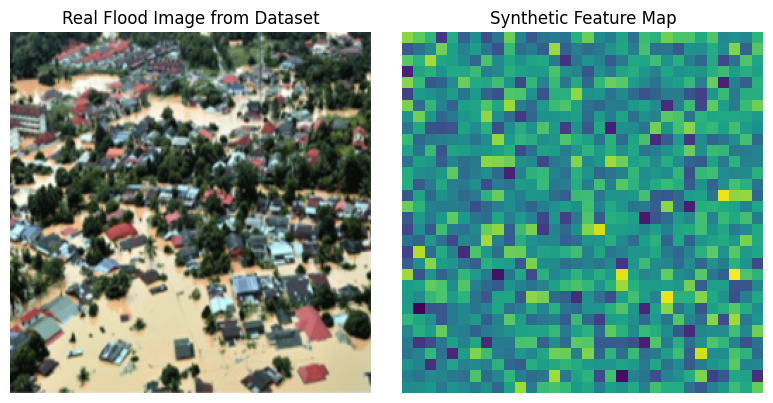


Dropout Techniques for Regularization:

1. Standard Dropout (p=0.3):
Zeros created: 69632/262144 (26.6%)


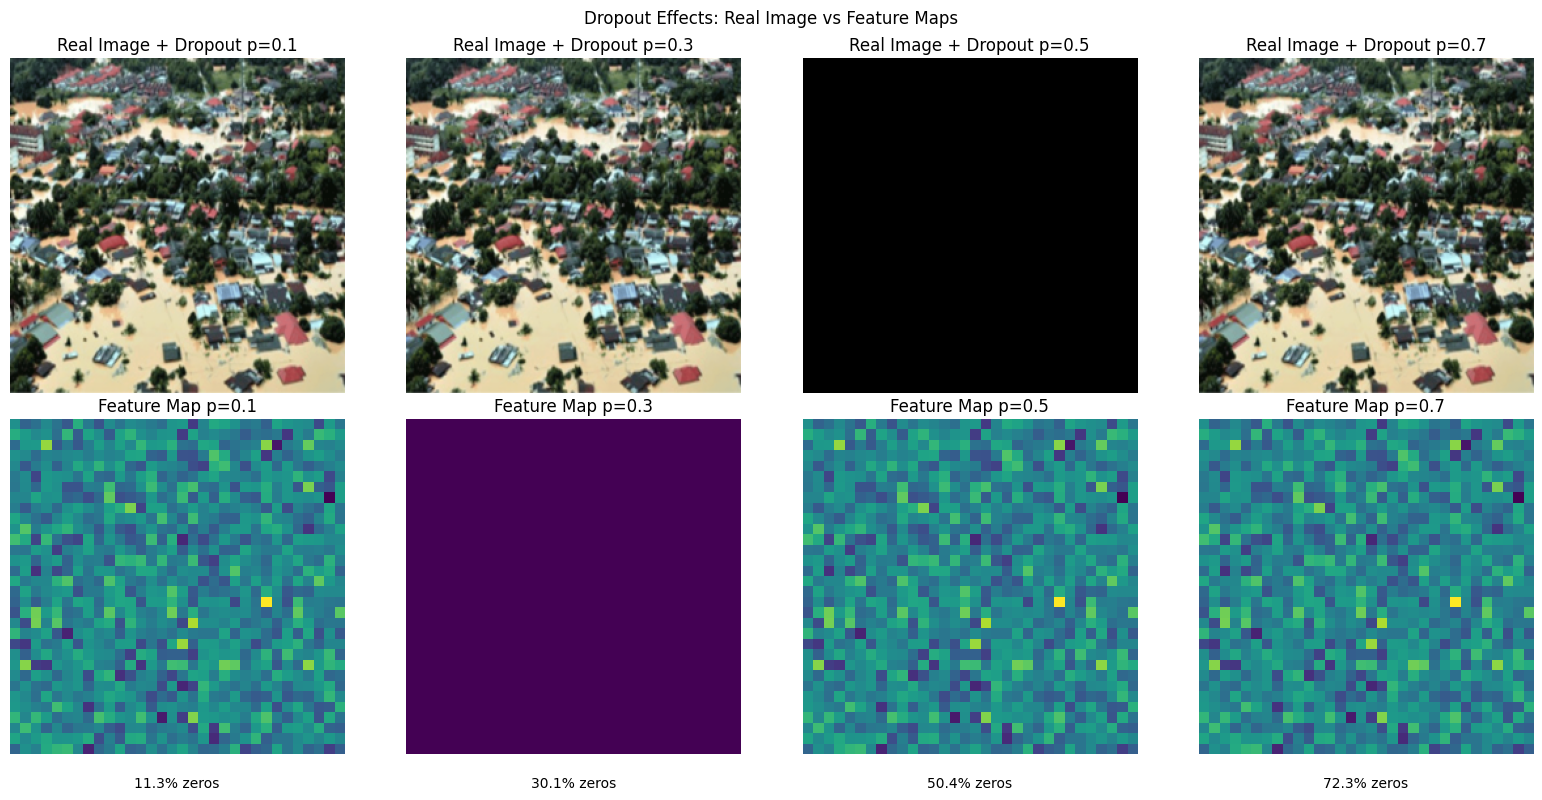

In [2]:
class NormalizationShowcase:
    """Demonstrate different normalization techniques for flood segmentation"""
    
    def __init__(self):
        self.batch_size = 4
        self.channels = 64
        self.height = 32
        self.width = 32
        self.load_real_image()
    
    def load_real_image(self):
        """Load a consistent real image from the dataset"""
        try:
            image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if image_files:
                image_files.sort()
                selected_image = image_files[0]
                img_path = os.path.join(IMAGES_DIR, selected_image)
                image = Image.open(img_path).convert('RGB')
                transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor()
                ])
                self.real_image = transform(image).unsqueeze(0)  # Add batch dimension
                print(f"Loaded consistent image: {selected_image}")
                print(f"Image shape: {self.real_image.shape}")
            else:
                self.real_image = None
                
        except Exception as e:
            print(f"Error loading real image: {e}")
            self.real_image = None
    
    def demonstrate_normalizations(self):
        x = torch.randn(self.batch_size, self.channels, self.height, self.width)
        if self.real_image is not None:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            img_display = self.real_image[0].permute(1, 2, 0).numpy()
            plt.imshow(img_display)
            plt.title('Real Flood Image from Dataset')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            sample_channel = x[0, 0].detach().cpu().numpy()
            plt.imshow(sample_channel, cmap='viridis')
            plt.title('Synthetic Feature Map')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # 1. Batch Normalization - most common for CNNs
        bn = nn.BatchNorm2d(self.channels)
        x_bn = bn(x)
        
        # 2. Instance Normalization - good for style-sensitive tasks
        in_norm = nn.InstanceNorm2d(self.channels)
        x_in = in_norm(x)
        
        # 3. Group Normalization - stable alternative to BatchNorm
        gn = nn.GroupNorm(8, self.channels)  # 8 groups
        x_gn = gn(x)
        
        # 4. Layer Normalization
        ln = nn.LayerNorm([self.channels, self.height, self.width])
        x_ln = ln(x)
        
        return x_bn, x_in, x_gn, x_ln
    
    def demonstrate_dropout(self):
        x = torch.randn(self.batch_size, self.channels, self.height, self.width)
        print("=" * 50)
        print("\nDropout Techniques for Regularization:")
        
        # 1. Standard Dropout
        dropout = nn.Dropout2d(p=0.3)
        x_dropout = dropout(x)
        zeros_count = (x_dropout == 0).sum().item()
        total_elements = x_dropout.numel()
        print(f"\n1. Standard Dropout (p=0.3):")
        print(f"Zeros created: {zeros_count}/{total_elements} ({zeros_count/total_elements*100:.1f}%)")
        
        # 2. Different dropout rates with real image comparison
        dropout_rates = [0.1, 0.3, 0.5, 0.7]
        
        if self.real_image is not None:
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            # First row: Real image with different dropout rates applied
            for i, p in enumerate(dropout_rates):
                drop = nn.Dropout2d(p=p)
                real_features = torch.randn(1, 3, 256, 256)
                dropped_features = drop(real_features)
                img_display = self.real_image[0].permute(1, 2, 0).numpy()
                mask = (dropped_features[0, 0] != 0).float().numpy()
                masked_img = img_display * mask[:, :, np.newaxis]
                axes[0, i].imshow(masked_img)
                axes[0, i].set_title(f'Real Image + Dropout p={p}')
                axes[0, i].axis('off')
            
            # Second row: Feature maps with dropout
            for i, p in enumerate(dropout_rates):
                drop = nn.Dropout2d(p=p)
                x_drop = drop(x)
                sample_channel = x_drop[0, 0].detach().cpu()
                channel_data = np.array(sample_channel.tolist())
                axes[1, i].imshow(channel_data, cmap='viridis')
                axes[1, i].set_title(f'Feature Map p={p}')
                axes[1, i].axis('off')
                zeros = (x_drop == 0).sum().item()
                total = x_drop.numel()
                axes[1, i].text(0.5, -0.1, f'{zeros/total*100:.1f}% zeros', transform=axes[1, i].transAxes, ha='center')
            
            plt.suptitle('Dropout Effects: Real Image vs Feature Maps')
            
        else:
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))            
            for i, p in enumerate(dropout_rates):
                drop = nn.Dropout2d(p=p)
                x_drop = drop(x)
                sample_channel = x_drop[0, 0].detach().cpu()
                channel_data = np.array(sample_channel.tolist())
                axes[i].imshow(channel_data, cmap='viridis')
                axes[i].set_title(f'Dropout p={p}')
                axes[i].axis('off')
                zeros = (x_drop == 0).sum().item()
                total = x_drop.numel()
                axes[i].text(0.5, -0.1, f'{zeros/total*100:.1f}% zeros', transform=axes[i].transAxes, ha='center')
            
            plt.suptitle('Effect of Different Dropout Rates on Feature Maps')
        
        plt.tight_layout()
        plt.show()
        
        return x_dropout

norm_demo = NormalizationShowcase()
normalized_outputs = norm_demo.demonstrate_normalizations()
dropout_output = norm_demo.demonstrate_dropout()

### Observations:

1. Batch Normalization:
   Input shape: torch.Size([4, 64, 32, 32])
   Output stats - Mean: 0.0000, Std: 1.0000
   Use case: Standard for CNN layers in segmentation networks

2. Instance Normalization:
   Output stats - Mean: 0.0000, Std: 1.0000
   Use case: When batch size is small or style matters

3. Group Normalization:
   Output stats - Mean: 0.0000, Std: 1.0000
   Use case: Batch-size independent, good for segmentation

4. Layer Normalization:
   Output stats - Mean: 0.0000, Std: 1.0000
   Use case: RNNs and Transformers mainly


# 2: Activation Functions


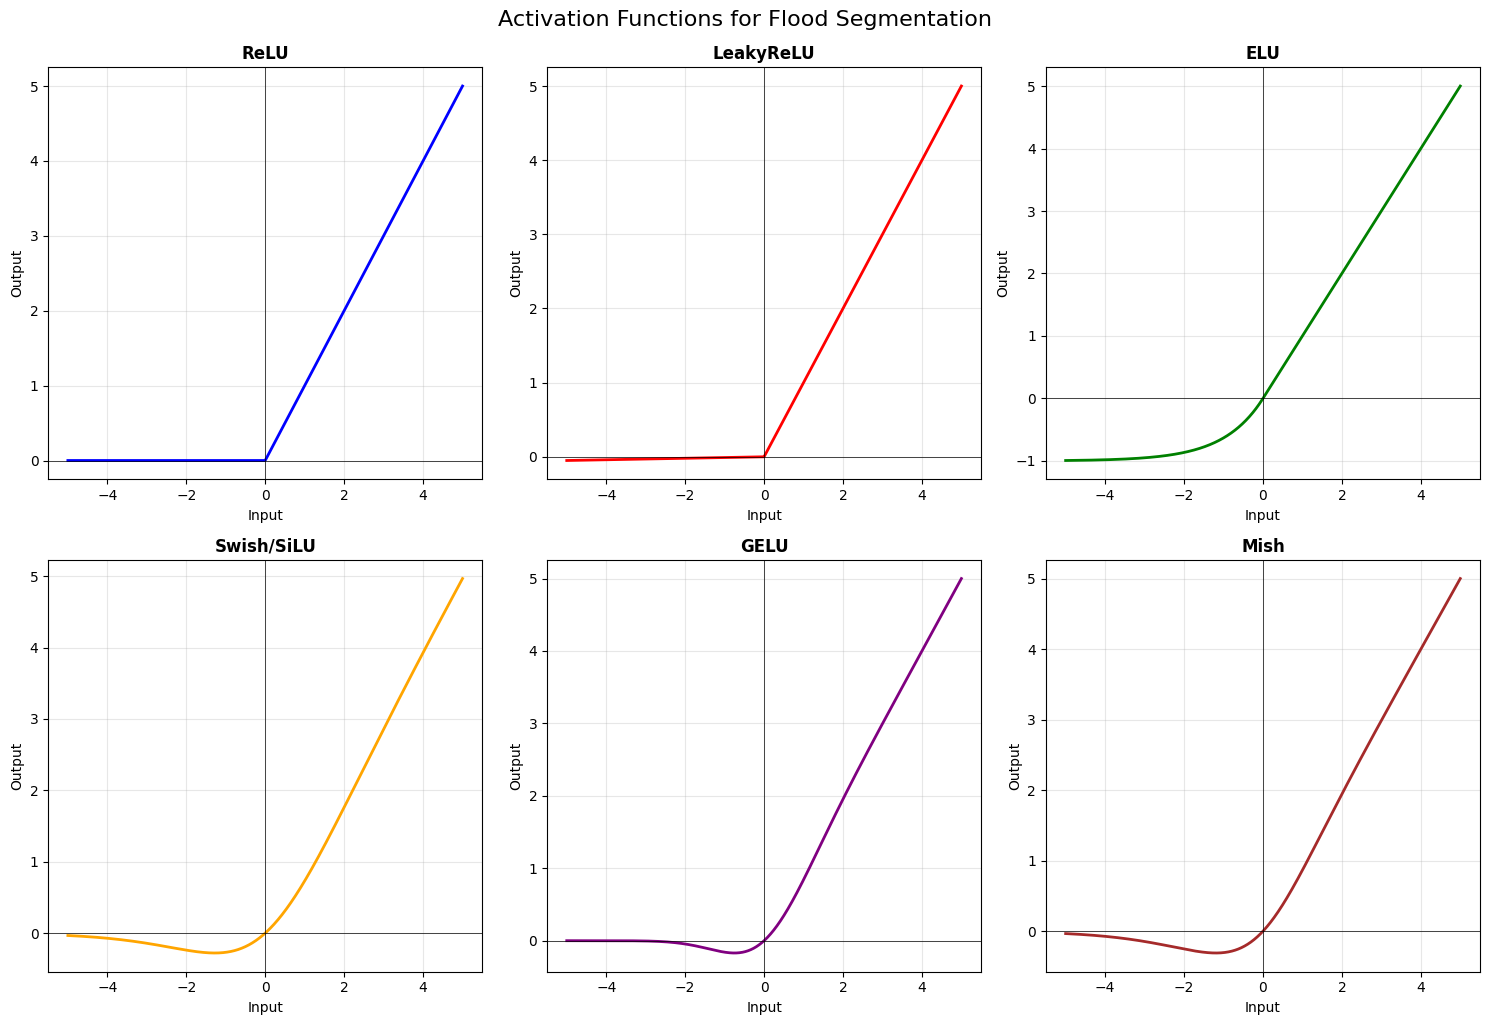

ReLU        : Mean grad =  0.500, Std =  0.500
LeakyReLU   : Mean grad =  0.505, Std =  0.495
Swish       : Mean grad =  0.500, Std =  0.515
GELU        : Mean grad =  0.500, Std =  0.514


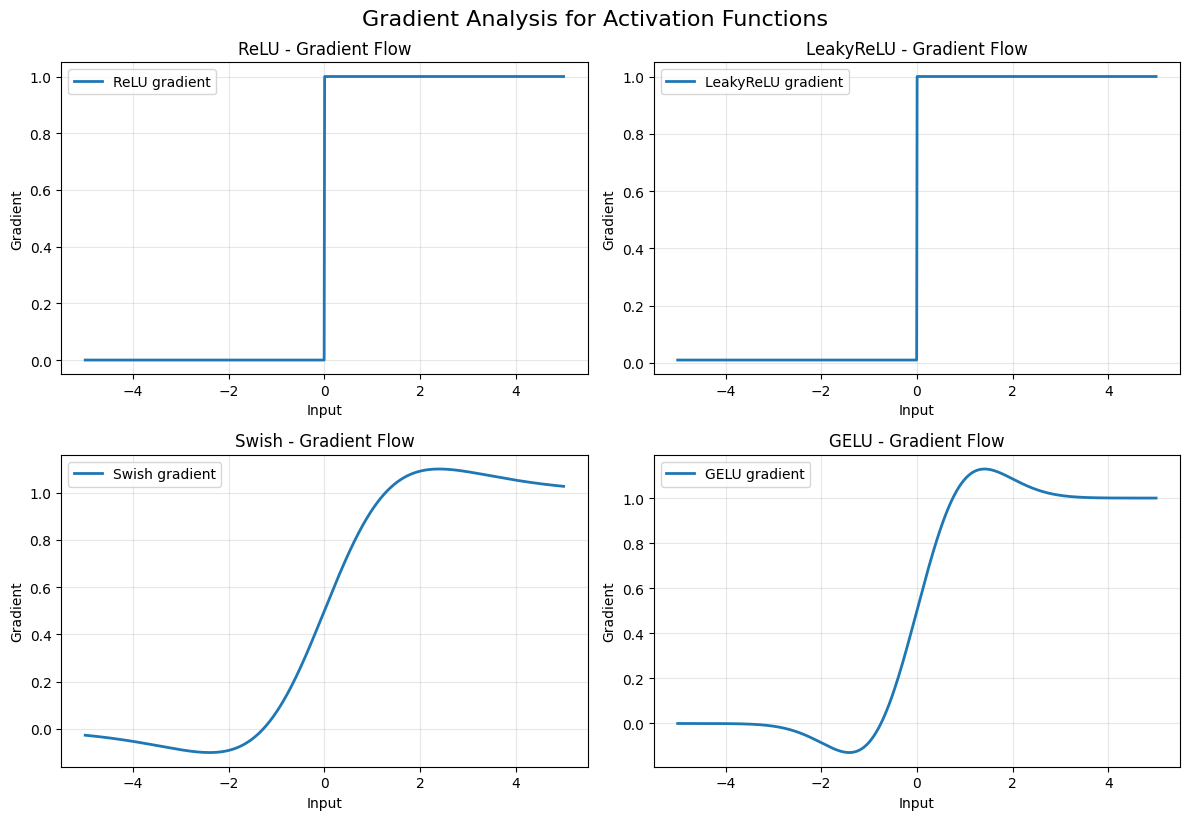

In [3]:
class ActivationFunctionAnalysis:
    """Analyze different activation functions for flood segmentation"""
    
    def __init__(self):
        self.x = torch.linspace(-5, 5, 1000)
        
    def compare_activations(self):
        activations = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(0.01),
            'ELU': nn.ELU(),
            'Swish/SiLU': nn.SiLU(),
            'GELU': nn.GELU(),
            'Mish': nn.Mish()
        }

        outputs = {}
        for name, activation in activations.items():
            outputs[name] = activation(self.x)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
        
        for i, (name, output) in enumerate(outputs.items()):
            # Convert tensors to Python lists for matplotlib compatibility
            x_vals = self.x.detach().cpu().tolist()
            out_vals = output.detach().cpu().tolist()
            axes[i].plot(x_vals, out_vals, color=colors[i], linewidth=2)
            axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='black', linewidth=0.5)
            axes[i].axvline(x=0, color='black', linewidth=0.5)
            axes[i].set_xlabel('Input')
            axes[i].set_ylabel('Output')
        
        plt.tight_layout()
        plt.suptitle('Activation Functions for Flood Segmentation', fontsize=16, y=1.02)
        plt.show()
        
        return outputs
    
    def analyze_gradients(self):
        x = torch.linspace(-5, 5, 1000, requires_grad=True)
        
        activations = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(0.01),
            'Swish': nn.SiLU(),
            'GELU': nn.GELU()
        }
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        
        for i, (name, activation) in enumerate(activations.items()):
            if x.grad is not None:
                x.grad.zero_()
            
            y = activation(x)
            gradients = torch.autograd.grad(outputs=y, inputs=x, 
                                            grad_outputs=torch.ones_like(y), 
                                            create_graph=False, retain_graph=False)[0]
            
            x_vals = x.detach().cpu().tolist()
            grad_vals = gradients.detach().cpu().tolist()
            axes[i].plot(x_vals, grad_vals, linewidth=2, label=f'{name} gradient')
            axes[i].set_title(f'{name} - Gradient Flow')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlabel('Input')
            axes[i].set_ylabel('Gradient')
            axes[i].legend()
            
            grad_mean = gradients.mean().item()
            grad_std = gradients.std().item()
            print(f"{name:12}: Mean grad = {grad_mean:6.3f}, Std = {grad_std:6.3f}")
            
        plt.tight_layout()
        plt.suptitle('Gradient Analysis for Activation Functions', fontsize=16, y=1.02)
        plt.show()

activation_analyzer = ActivationFunctionAnalysis()
outputs = activation_analyzer.compare_activations()
activation_analyzer.analyze_gradients()

### Observations and Recommendations about activattion functions:

1. ReLU: Simple, fast, but can cause dead neurons

   - Use in: Standard convolutional layers
   - Avoid: Very deep networks (gradient vanishing)

2. LeakyReLU: Prevents dead neurons, allows small negative gradients

   - Use in: Hidden layers, especially deeper networks
   - Best for: General purpose flood segmentation

3. ELU: Smooth, bounded below, faster convergence

   - Use in: Deep networks where training speed matters
   - Note: Slightly more computation than ReLU

4. Swish/SiLU: Self-gated, smooth, good for deep networks

   - Use in: Complex segmentation tasks
   - Best for: When you want state-of-the-art performance

5. GELU: Gaussian-based, smooth, popular in transformers

   - Use in: Attention-based segmentation networks
   - Best for: Vision transformers for segmentation

6. Mish: Self-regularizing, unbounded above, bounded below
   - Use in: When you want best possible accuracy
   - Note: More computationally expensive


# 3: Model Architectures for Segmentation


In [4]:
def summarize_model(model, input_size=(3, 256, 256)):
    # Create a simple summary similar to TensorFlow's model.summary()
    print("=" * 80)
    print(f"Model: {model.__class__.__name__}")
    print("=" * 80)
    print(f"{'Layer (type)':<30} {'Output Shape':<20} {'Param #':<15}")
    print("=" * 80)

    # Create dummy input to trace through the model
    dummy_input = torch.randn(1, *input_size)

    # Hook to capture layer outputs
    layer_outputs = {}
    def hook_fn(name):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                layer_outputs[name] = output.shape
            elif isinstance(output, (list, tuple)) and len(output) > 0:
                layer_outputs[name] = output[0].shape
        return hook

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            hook = module.register_forward_hook(hook_fn(name))
            hooks.append(hook)

    # Forward pass to get shapes
    with torch.no_grad():
        _ = model(dummy_input)

    # Print layer information
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            param_count = sum(p.numel() for p in module.parameters())
            if name in layer_outputs and param_count > 0:
                output_shape = str(list(layer_outputs[name]))
                layer_type = module.__class__.__name__
                print(f"{name + f' ({layer_type})':<30} {output_shape:<20} {param_count:<15,}")
                total_params += param_count

    # Remove hooks
    for hook in hooks:
        hook.remove()

    print("=" * 80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"Non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")
    print("=" * 80)


Model Architecture: FloodSegmentationCNN
Total parameters: 24,775,746
Trainable parameters: 24,775,746
Model size: 94.51 MB (float32)

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 2, 256, 256])

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 2, 256, 256])


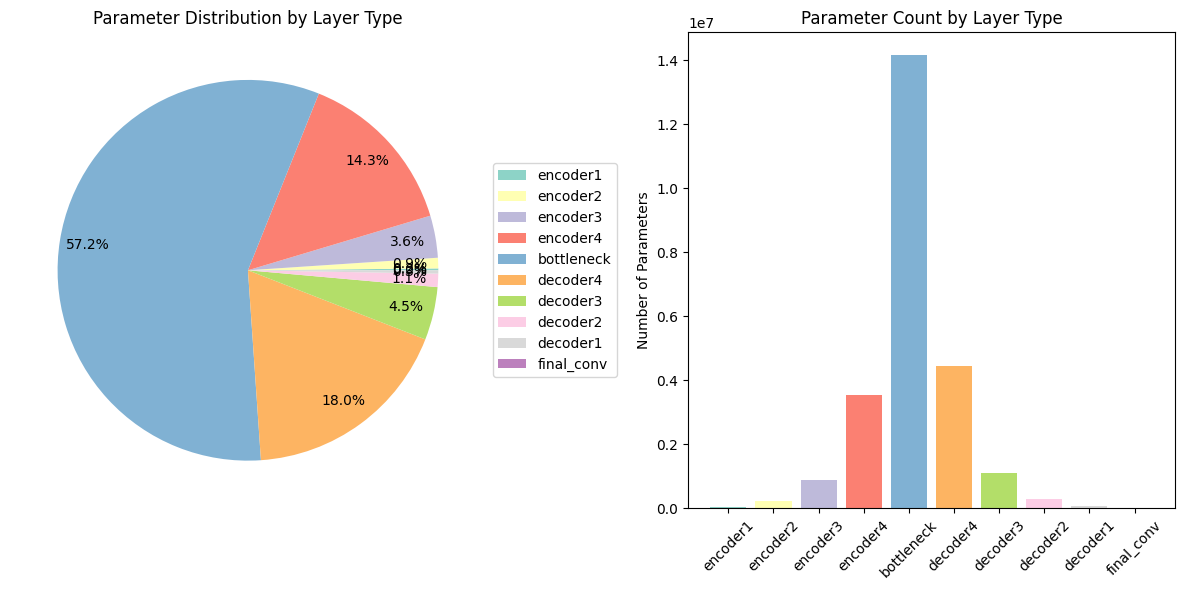

Model: FloodSegmentationCNN
Layer (type)                   Output Shape         Param #        
encoder1.0 (Conv2d)            [1, 64, 256, 256]    1,792          
encoder1.1 (BatchNorm2d)       [1, 64, 256, 256]    128            
encoder1.3 (Conv2d)            [1, 64, 256, 256]    36,928         
encoder1.4 (BatchNorm2d)       [1, 64, 256, 256]    128            
encoder2.0 (Conv2d)            [1, 128, 128, 128]   73,856         
encoder2.1 (BatchNorm2d)       [1, 128, 128, 128]   256            
encoder2.3 (Conv2d)            [1, 128, 128, 128]   147,584        
encoder2.4 (BatchNorm2d)       [1, 128, 128, 128]   256            
encoder3.0 (Conv2d)            [1, 256, 64, 64]     295,168        
encoder3.1 (BatchNorm2d)       [1, 256, 64, 64]     512            
encoder3.3 (Conv2d)            [1, 256, 64, 64]     590,080        
encoder3.4 (BatchNorm2d)       [1, 256, 64, 64]     512            
encoder4.0 (Conv2d)            [1, 512, 32, 32]     1,180,160      
encoder4.1 (BatchNor

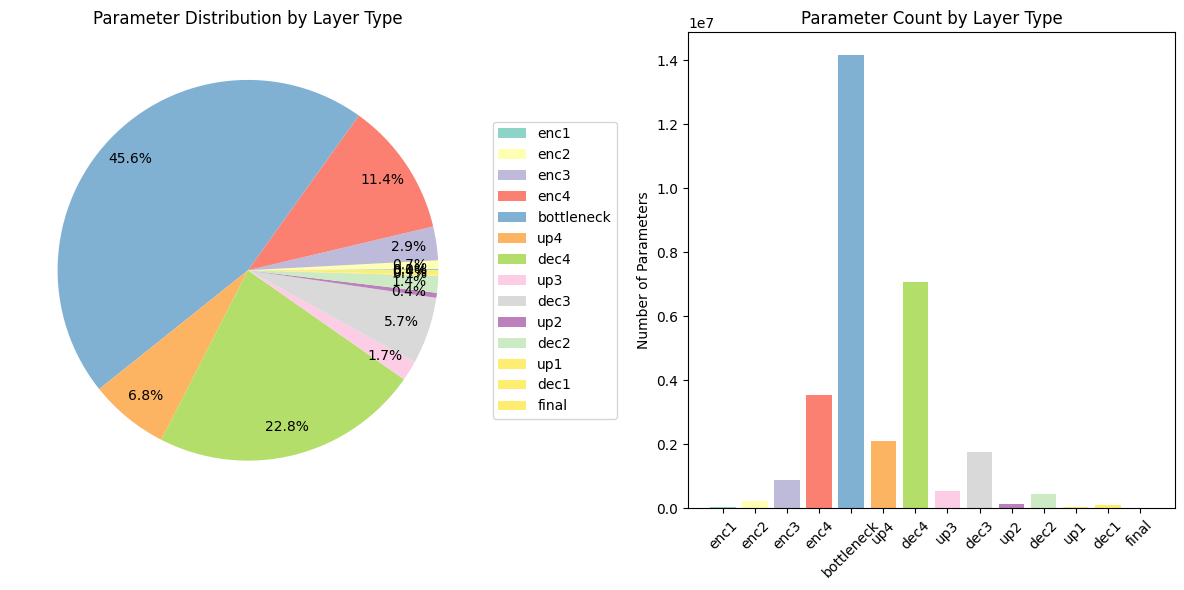

Model: UNetForFloodSegmentation
Layer (type)                   Output Shape         Param #        
enc1.0 (Conv2d)                [1, 64, 256, 256]    1,792          
enc1.1 (BatchNorm2d)           [1, 64, 256, 256]    128            
enc1.3 (Conv2d)                [1, 64, 256, 256]    36,928         
enc1.4 (BatchNorm2d)           [1, 64, 256, 256]    128            
enc2.0 (Conv2d)                [1, 128, 128, 128]   73,856         
enc2.1 (BatchNorm2d)           [1, 128, 128, 128]   256            
enc2.3 (Conv2d)                [1, 128, 128, 128]   147,584        
enc2.4 (BatchNorm2d)           [1, 128, 128, 128]   256            
enc3.0 (Conv2d)                [1, 256, 64, 64]     295,168        
enc3.1 (BatchNorm2d)           [1, 256, 64, 64]     512            
enc3.3 (Conv2d)                [1, 256, 64, 64]     590,080        
enc3.4 (BatchNorm2d)           [1, 256, 64, 64]     512            
enc4.0 (Conv2d)                [1, 512, 32, 32]     1,180,160      
enc4.1 (BatchNor

In [5]:
class FloodSegmentationCNN(nn.Module):
    """Custom CNN architecture for flood segmentation"""
    
    def __init__(self, input_channels=3, num_classes=2):
        super(FloodSegmentationCNN, self).__init__()
        
        # Encoder (Contracting Path)
        self.encoder1 = self._make_encoder_block(input_channels, 64)
        self.encoder2 = self._make_encoder_block(64, 128)
        self.encoder3 = self._make_encoder_block(128, 256)
        self.encoder4 = self._make_encoder_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self._make_encoder_block(512, 1024)
        
        # Decoder (Expanding Path)
        self.decoder4 = self._make_decoder_block(1024, 512)
        self.decoder3 = self._make_decoder_block(512, 256)
        self.decoder2 = self._make_decoder_block(256, 128)
        self.decoder1 = self._make_decoder_block(128, 64)
        
        # Final classifier
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.3)
        
    def _make_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    
    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool(e1)
        
        e2 = self.encoder2(p1)
        p2 = self.pool(e2)
        
        e3 = self.encoder3(p2)
        p3 = self.pool(e3)
        
        e4 = self.encoder4(p3)
        p4 = self.pool(e4)
        
        # Bottleneck
        bottleneck = self.bottleneck(p4)
        bottleneck = self.dropout(bottleneck)
        
        # Decoder
        d4 = self.decoder4(bottleneck)
        d3 = self.decoder3(d4)
        d2 = self.decoder2(d3)
        d1 = self.decoder1(d2)
        
        # Final output
        output = self.final_conv(d1)
        return output


class UNetForFloodSegmentation(nn.Module):
    """U-Net architecture specifically designed for flood segmentation"""
    
    def __init__(self, input_channels=3, num_classes=2):
        super(UNetForFloodSegmentation, self).__init__()
        
        # Encoder
        self.enc1 = self._make_layer(input_channels, 64)
        self.enc2 = self._make_layer(64, 128)
        self.enc3 = self._make_layer(128, 256)
        self.enc4 = self._make_layer(256, 512)
        
        # Bottleneck
        self.bottleneck = self._make_layer(512, 1024)
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self._make_layer(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self._make_layer(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self._make_layer(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self._make_layer(128, 64)
        
        self.final = nn.Conv2d(64, num_classes, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  # Using Swish for better performance
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    
    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        pool1 = self.pool(enc1)
        
        enc2 = self.enc2(pool1)
        pool2 = self.pool(enc2)
        
        enc3 = self.enc3(pool2)
        pool3 = self.pool(enc3)
        
        enc4 = self.enc4(pool3)
        pool4 = self.pool(enc4)
        
        # Bottleneck
        bottleneck = self.bottleneck(pool4)
        
        # Decoder path with skip connections
        up4 = self.up4(bottleneck)
        cat4 = torch.cat([up4, enc4], dim=1)
        dec4 = self.dec4(cat4)
        
        up3 = self.up3(dec4)
        cat3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.dec3(cat3)
        
        up2 = self.up2(dec3)
        cat2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2(cat2)
        
        up1 = self.up1(dec2)
        cat1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.dec1(cat1)
        
        return self.final(dec1)


def visualize_architecture(model, input_size=(3, 256, 256)):
    """Visualize the model architecture and parameter count"""
    
    print(f"Model Architecture: {model.__class__.__name__}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: {total_params * 4 / 1024**2:.2f} MB (float32)")
    
    # Test forward pass
    # Use actual image data instead of random tensor
    sample_image_path = os.path.join(IMAGES_DIR, metadata_df.iloc[0]['Image'])
    sample_image = Image.open(sample_image_path)
    
    # Ensure image is RGB format
    if sample_image.mode != 'RGB':
        sample_image = sample_image.convert('RGB')
    
    # Convert to tensor and add batch dimension
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    dummy_input = transform(sample_image).unsqueeze(0)
    with torch.no_grad():
        output = model(dummy_input)
    
    print(f"\nInput shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")
    
    # Visualize layer-wise parameter distribution
    layer_params = {}
    for name, param in model.named_parameters():
        layer_type = name.split('.')[0]
        if layer_type not in layer_params:
            layer_params[layer_type] = 0
        layer_params[layer_type] += param.numel()
    
    # Plot parameter distribution
    plt.figure(figsize=(12, 6))
    layers = list(layer_params.keys())
    params = list(layer_params.values())
    
    plt.subplot(1, 2, 1)
    colors = plt.cm.Set3(range(len(layers)))  # Generate colors for pie chart
    plt.pie(params, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
    plt.legend(layers, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Parameter Distribution by Layer Type')
    
    plt.subplot(1, 2, 2)
    plt.bar(layers, params, color=colors)  # Use same colors for bar chart
    plt.title('Parameter Count by Layer Type')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Parameters')
    
    plt.tight_layout()
    plt.show()

# Model 1: Custom CNN
model_cnn = FloodSegmentationCNN(input_channels=3, num_classes=2)
visualize_architecture(model_cnn)
summarize_model(model_cnn)
# Model 2: U-Net
model_unet = UNetForFloodSegmentation(input_channels=3, num_classes=2)
visualize_architecture(model_unet)
summarize_model(model_unet)

# 4: Data Preprocessing for Flood Segmentation



Dataset Stats:
Total samples: 290
Samples analyzed: 50
Average flood coverage: 41.25%
Average non-flood coverage: 58.75%
Classes are reasonably balanced


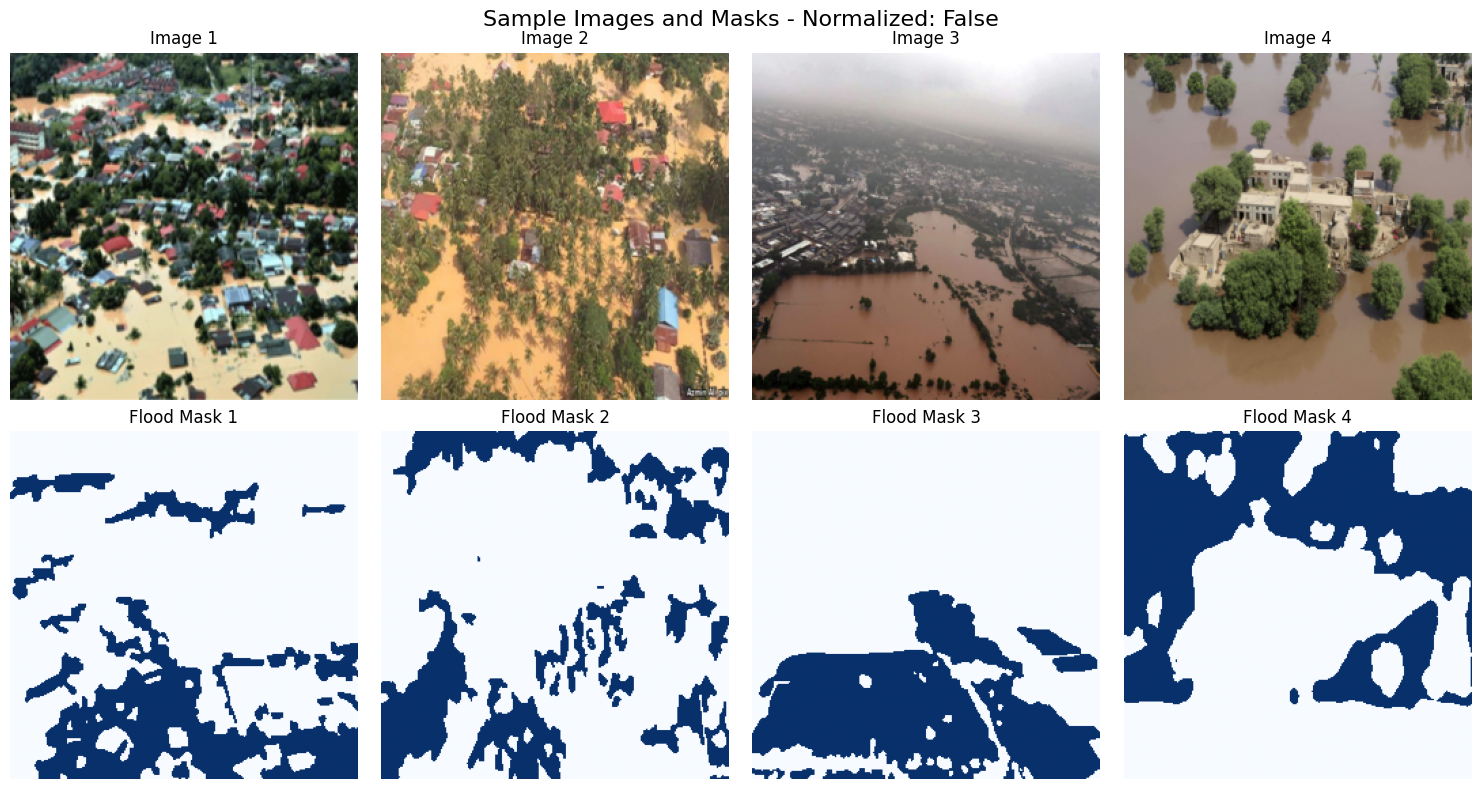

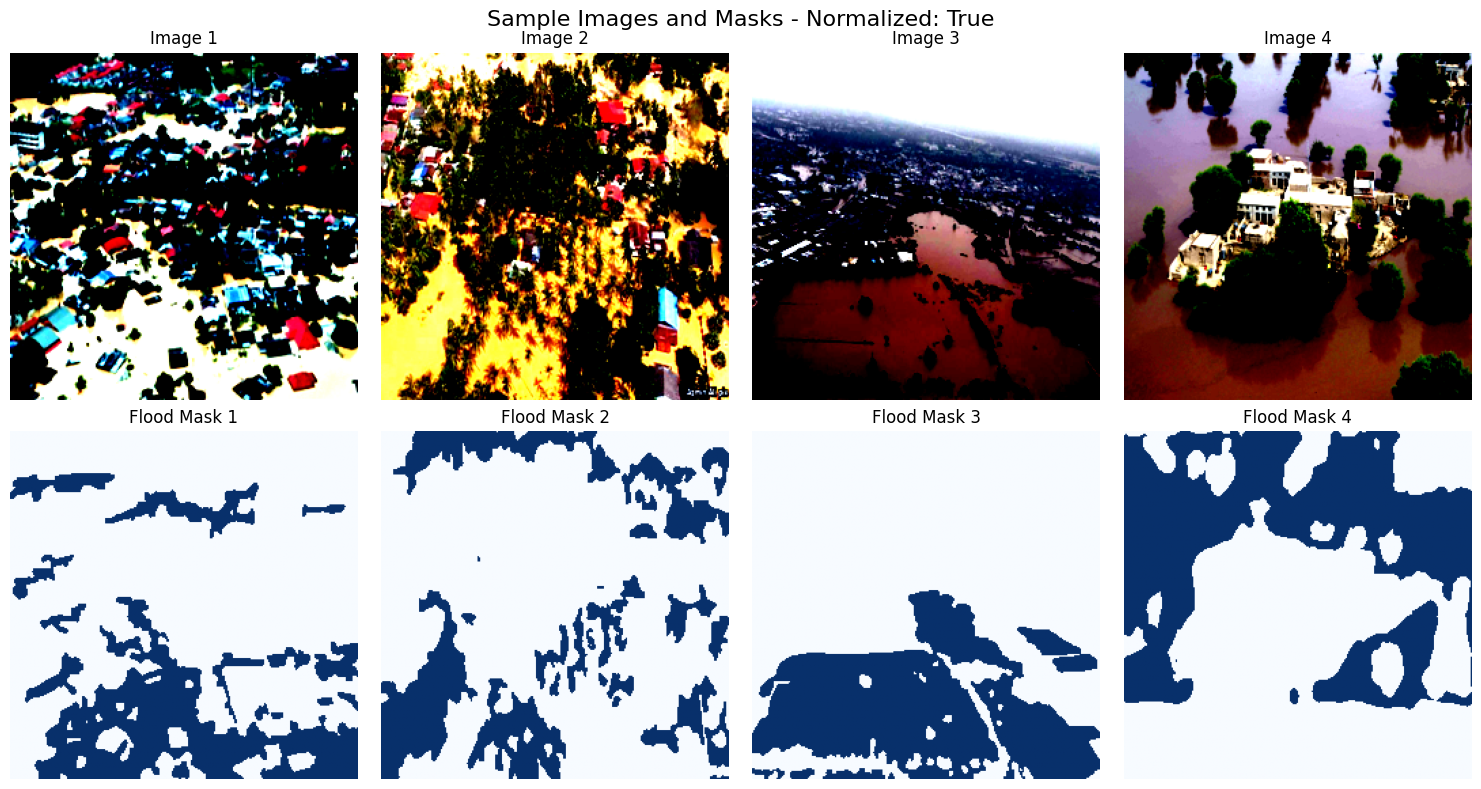

In [6]:
class FloodDataset(Dataset):
    """Custom Dataset for flood segmentation"""
    
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get all image files
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        # Load mask (assuming same filename but possibly different extension)
        mask_name = os.path.splitext(self.image_files[idx])[0]
        
        # Try different mask extensions
        mask_extensions = ['.png', '.jpg', '.jpeg']
        mask = None
        
        for ext in mask_extensions:
            mask_path = os.path.join(self.masks_dir, mask_name + ext)
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')  # Grayscale
                break
        
        if mask is None:
            raise FileNotFoundError(f"No mask found for {self.image_files[idx]}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0: non-flood, 1: flood)
        # Assuming white pixels (255) represent flood areas
        if isinstance(mask, torch.Tensor):
            mask = (mask > 0.5).float()
        else:
            mask = np.array(mask)
            mask = (mask > 128).astype(np.float32)
            mask = torch.from_numpy(mask)
        
        return image, mask


def create_transforms():
    """Create preprocessing transforms"""
    
    # Image transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])
    
    # Mask transforms (no normalization for masks)
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    return image_transform, mask_transform


def visualize_data_samples(dataset, num_samples=4, DENORMALIZED=True):
    """Visualize sample images and masks from the dataset"""
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i in range(num_samples):
        # Get sample
        if i < len(dataset):
            image, mask = dataset[i]
        else:
            break
            
        # Denormalize image for visualization
        if isinstance(image, torch.Tensor):
            # Denormalize
            if DENORMALIZED:
                mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
                image_vis = image * std + mean
                image_vis = torch.clamp(image_vis, 0, 1)
                image_vis = image_vis.permute(1, 2, 0).numpy()
            else:
                image = torch.clamp(image, 0, 1)
                image_vis = image.permute(1, 2, 0).numpy()
        else:
            image_vis = image
            
        if isinstance(mask, torch.Tensor):
            mask_vis = mask.squeeze().numpy()
        else:
            mask_vis = mask
        
        # Plot image
        axes[0, i].imshow(image_vis)
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')
        
        # Plot mask
        axes[1, i].imshow(mask_vis, cmap='Blues')
        axes[1, i].set_title(f'\nFlood Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Sample Images and Masks - Normalized: {not DENORMALIZED}', fontsize=16)
    plt.tight_layout()
    plt.show()


def analyze_dataset_statistics(dataset):
    
    total_samples = len(dataset)
    flood_pixels = 0
    total_pixels = 0
    
    # Sample a subset for analysis (to avoid memory issues)
    sample_indices = np.random.choice(len(dataset), min(50, len(dataset)), replace=False)
    
    for idx in sample_indices:
        _, mask = dataset[idx]
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = mask
            
        flood_pixels += np.sum(mask_np > 0.5)
        total_pixels += mask_np.size
    
    # Calculate statistics
    flood_ratio = flood_pixels / total_pixels
    print("\nDataset Stats:")
    print(f"Total samples: {total_samples}")
    print(f"Samples analyzed: {len(sample_indices)}")
    print(f"Average flood coverage: {flood_ratio:.2%}")
    print(f"Average non-flood coverage: {1-flood_ratio:.2%}")
    
    # Class imbalance check
    if flood_ratio < 0.1:
        print("Warning: Severe class imbalance detected!")
        print("Consider using weighted loss functions")
    elif flood_ratio < 0.3:
        print("Warning: Moderate class imbalance detected!")
    else:
        print("Classes are reasonably balanced")
    
    return flood_ratio

def create_data_loaders(images_dir, masks_dir, batch_size=8, train_split=0.8):
    # Create transforms
    image_transform, mask_transform = create_transforms()
    
    # Create full dataset
    full_dataset = FloodDataset(images_dir, masks_dir, 
                                image_transform, mask_transform)
    
    # Split dataset
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size])
    
    # Create data loaders (num_workers=0 to avoid multiprocessing issues on macOS)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"\nData Loader:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Batch size: {batch_size}")
    
    return train_loader, val_loader, full_dataset

dataset = FloodDataset(IMAGES_DIR, MASKS_DIR, *create_transforms())

analyze_dataset_statistics(dataset=dataset)
visualize_data_samples(dataset=dataset, num_samples=4, DENORMALIZED=True)
visualize_data_samples(dataset=dataset, num_samples=4, DENORMALIZED=False)

# 5: Data Augmentation for Flood Segmentation


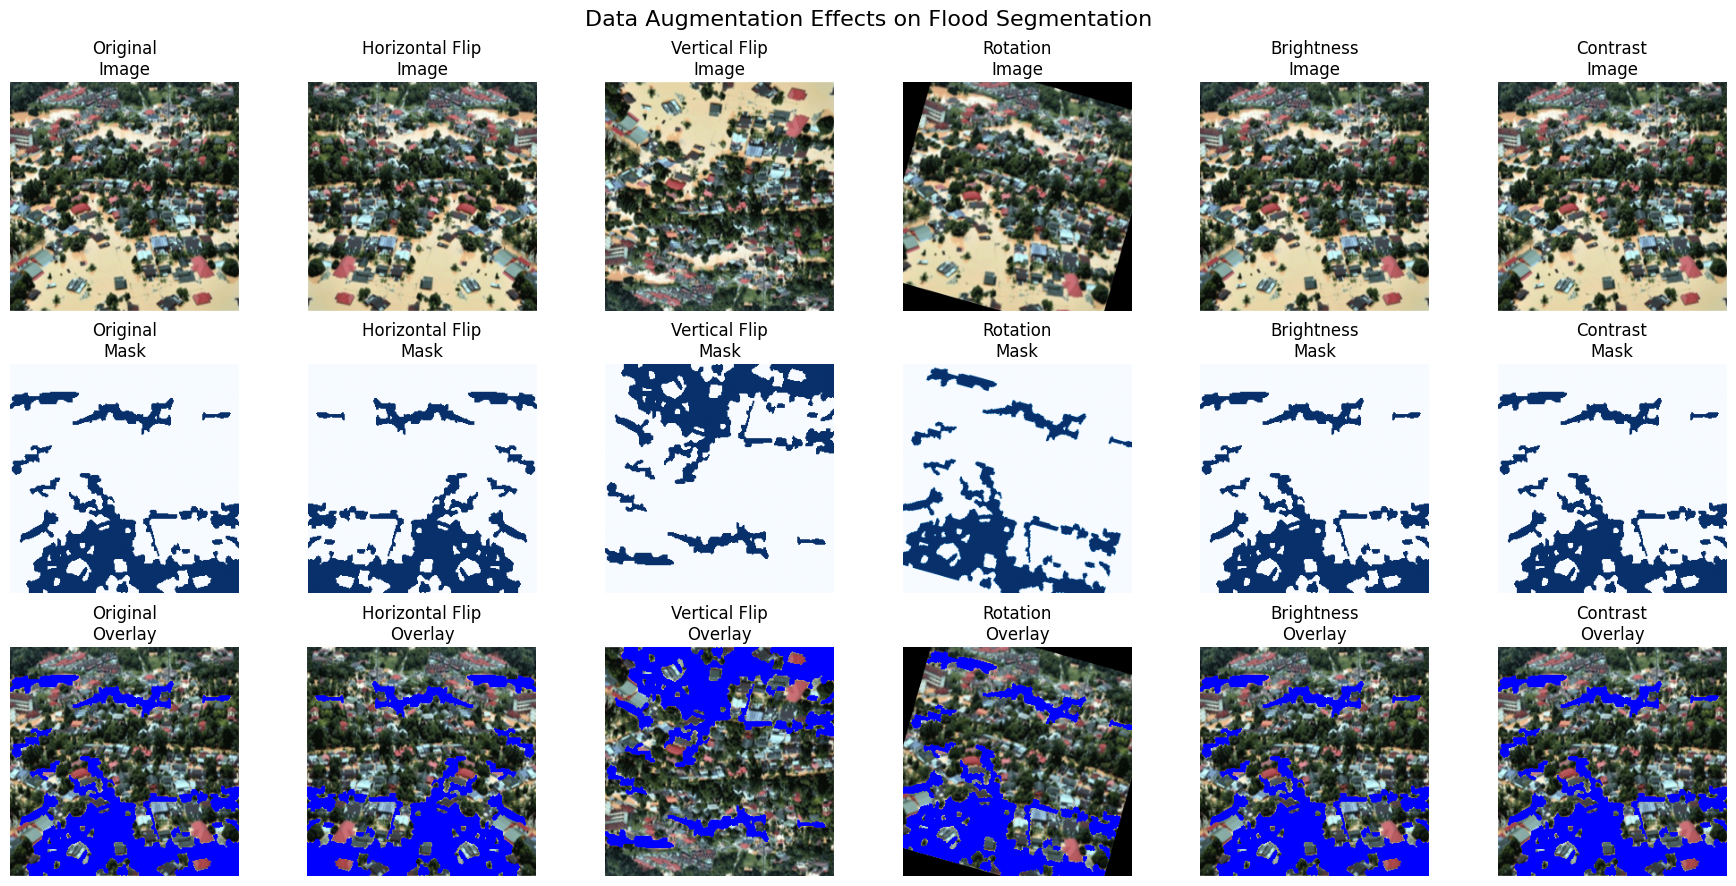

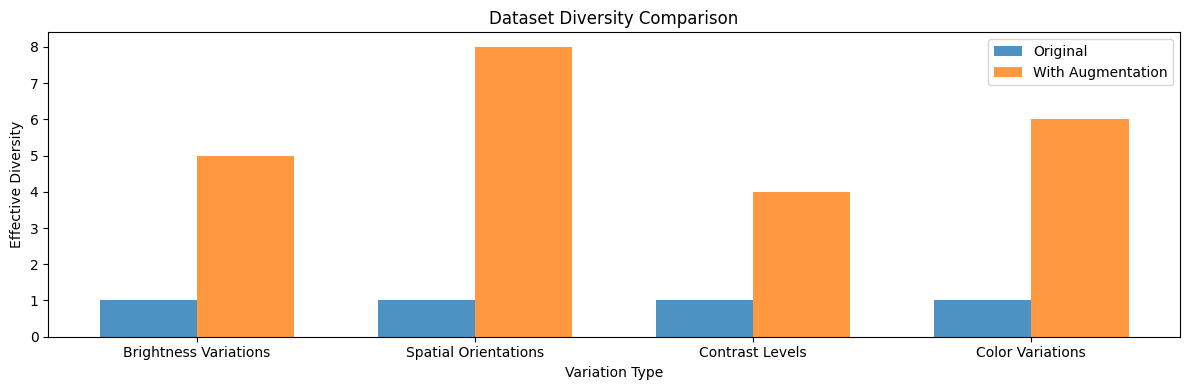

In [7]:
class FloodAugmentationDataset(Dataset):
    """Enhanced dataset with data augmentation for flood segmentation"""
    
    def __init__(self, images_dir, masks_dir, augment=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.augment = augment
        
        # Get all image files
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        # Validate that we have images
        if len(self.image_files) == 0:
            raise ValueError(f"No image files found in {images_dir}")
        
        # Base transforms
        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        
        # Normalization transform (applied after augmentation)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        # Load mask
        mask_name = os.path.splitext(self.image_files[idx])[0]
        mask_extensions = ['.png', '.jpg', '.jpeg']
        mask = None
        
        for ext in mask_extensions:
            mask_path = os.path.join(self.masks_dir, mask_name + ext)
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                break
        
        # Apply base transforms
        image = self.base_transform(image)
        mask = self.base_transform(mask)
        
        # Apply augmentations if enabled
        if self.augment:
            image, mask = apply_augmentation(image, mask)
            # Convert back to tensors
            image = self.base_transform(image)
            mask = self.base_transform(mask)
        
        # Normalize image
        image = self.normalize(image)
        
        # Convert mask to binary
        mask = (mask > 0.5).float()
        
        return image, mask

def apply_augmentation(image, mask, augmentation_type=None):
    """Apply synchronized augmentations to image and mask"""
    
    # Convert to numpy for OpenCV operations
    if isinstance(image, torch.Tensor):
        image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    else:
        image_np = np.array(image)
        
    if isinstance(mask, torch.Tensor):
        # Handle both 2D and 3D tensors
        if mask.dim() == 3:
            mask_np = (mask.squeeze().numpy() * 255).astype(np.uint8)
        else:
            mask_np = (mask.numpy() * 255).astype(np.uint8)
    else:
        mask_np = np.array(mask)
    
    # Random horizontal flip
    if augmentation_type == 'horizontal_flip' or (augmentation_type is None and np.random.random() > 0.5):
        image_np = cv2.flip(image_np, 1)
        mask_np = cv2.flip(mask_np, 1)
    
    # Random vertical flip
    if augmentation_type == 'vertical_flip' or (augmentation_type is None and np.random.random() > 0.5):
        image_np = cv2.flip(image_np, 0)
        mask_np = cv2.flip(mask_np, 0)
    
    # Random rotation (small angles to preserve flood patterns)
    if augmentation_type == 'rotation' or (augmentation_type is None and np.random.random() > 0.5):
        angle = np.random.uniform(-30, 30)
        h, w = image_np.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        image_np = cv2.warpAffine(image_np, M, (w, h))
        mask_np = cv2.warpAffine(mask_np, M, (w, h))
    
    # Random brightness and contrast (only for image)
    if augmentation_type == 'brightness_contrast' or (augmentation_type is None and np.random.random() > 0.5):
        alpha = np.random.uniform(0.8, 1.2)  # Contrast
        beta = np.random.uniform(-20, 20)    # Brightness
        image_np = cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
    
    # Random color shift (only for image)
    if augmentation_type == 'color_shift' or (augmentation_type is None and np.random.random() > 0.5):
        # Slight color channel shifts
        shift = np.random.randint(-10, 10, 3)
        image_np = np.clip(image_np.astype(np.int16) + shift, 0, 255).astype(np.uint8)
    
    # Convert back to PIL Images
    image_aug = Image.fromarray(image_np)
    mask_aug = Image.fromarray(mask_np)
    
    return image_aug, mask_aug

def demonstrate_augmentations():
    """Demonstrate different augmentation techniques"""    
    # Load a real image and mask from the directories
    # Get the first image from the dataset
    sample_image_path = os.path.join(IMAGES_DIR, metadata_df.iloc[0]['Image'])
    sample_mask_path = os.path.join(MASKS_DIR, metadata_df.iloc[0]['Mask']) 
    
    # Load and preprocess the image
    sample_image_pil = Image.open(sample_image_path)
    if sample_image_pil.mode != 'RGB':
        sample_image_pil = sample_image_pil.convert('RGB')
    
    # Load and preprocess the mask
    sample_mask_pil = Image.open(sample_mask_path)
    if sample_mask_pil.mode != 'L':
        sample_mask_pil = sample_mask_pil.convert('L')
    
    # Convert to tensors
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    sample_image = transform(sample_image_pil)
    sample_mask = transform(sample_mask_pil)
    sample_mask = (sample_mask > 0.5).float()  # Convert to binary mask
    
    # Define augmentation techniques
    augmentations = [
        'Original',
        'Horizontal Flip',
        'Vertical Flip',
        'Rotation',
        'Brightness',
        'Contrast'
    ]
    
    # Visualize augmentations
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    
    for i, aug_name in enumerate(augmentations):
        if i < 6:
            if aug_name == 'Original':
                aug_image, aug_mask = sample_image, sample_mask
            else:
                aug_image, aug_mask = apply_augmentation(sample_image, sample_mask, augmentation_type=aug_name.lower().replace(' ', '_'))
            
            # Display image - Handle both PIL Images and tensors
            if isinstance(aug_image, torch.Tensor):
                img_display = np.clip(aug_image.permute(1, 2, 0).numpy(), 0, 1)
            else:
                img_display = np.array(aug_image) / 255.0 if np.array(aug_image).max() > 1 else np.array(aug_image)
            
            axes[0, i].imshow(img_display)
            axes[0, i].set_title(f'{aug_name}\nImage')
            axes[0, i].axis('off')
            
            # Display mask - Handle both PIL Images and tensors
            if isinstance(aug_mask, torch.Tensor):
                if aug_mask.dim() == 3:
                    mask_display = aug_mask.squeeze().numpy()
                else:
                    mask_display = aug_mask.numpy()
            else:
                mask_display = np.array(aug_mask) / 255.0 if np.array(aug_mask).max() > 1 else np.array(aug_mask)
            
            axes[1, i].imshow(mask_display, cmap='Blues')
            axes[1, i].set_title(f'{aug_name}\nMask')
            axes[1, i].axis('off')
            
            # Display overlay
            overlay = img_display.copy()
            if len(overlay.shape) == 2:  # Grayscale
                overlay = np.stack([overlay, overlay, overlay], axis=2)
            
            flood_areas = mask_display > 0.5
            overlay[flood_areas] = [0, 0, 1]  # Blue for flood areas
            axes[2, i].imshow(overlay)
            axes[2, i].set_title(f'{aug_name}\nOverlay')
            axes[2, i].axis('off')
    
    plt.suptitle('Data Augmentation Effects on Flood Segmentation', fontsize=16)
    plt.tight_layout()
    plt.show()

def create_augmented_loaders(images_dir, masks_dir, batch_size=8, train_split=0.8):
    """Create data loaders with and without augmentation"""
    
    # Training dataset with augmentation
    train_dataset_aug = FloodAugmentationDataset(images_dir, masks_dir, augment=True)
    
    # Validation dataset without augmentation
    val_dataset = FloodAugmentationDataset(images_dir, masks_dir, augment=False)
    
    # Split indices
    total_size = len(train_dataset_aug)
    indices = list(range(total_size))
    np.random.shuffle(indices)
    
    train_size = int(train_split * total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Create subsets
    train_subset = torch.utils.data.Subset(train_dataset_aug, train_indices)
    val_subset = torch.utils.data.Subset(val_dataset, val_indices)
    
    # Create loaders (num_workers=0 to avoid multiprocessing issues on macOS)
    train_loader = DataLoader(train_subset, batch_size=batch_size, 
                            shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, 
                            shuffle=False, num_workers=0)
    
    return train_loader, val_loader

def analyze_augmentation_impact():
    """Analyze the impact of data augmentation on flood segmentation"""    
    plt.figure(figsize=(12, 4))
    categories = ['Brightness Variations', 'Spatial Orientations', 'Contrast Levels', 'Color Variations']
    original = [1, 1, 1, 1]
    augmented = [5, 8, 4, 6]
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, original, width, label='Original', alpha=0.8)
    plt.bar(x + width/2, augmented, width, label='With Augmentation', alpha=0.8)
    plt.xlabel('Variation Type')
    plt.ylabel('Effective Diversity')
    plt.title('Dataset Diversity Comparison')
    plt.xticks(x, categories)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run demonstrations
demonstrate_augmentations()
analyze_augmentation_impact()

# 6: Transfer Learning for Flood Segmentation


In [8]:
class VGG16FloodSegmentation(nn.Module):
    """VGG16-based model for flood segmentation with frozen conv layers and retrained classifier"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(VGG16FloodSegmentation, self).__init__()
        
        # Load pretrained VGG16
        vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Extract features (convolutional layers)
        self.features = vgg16.features
        
        # Freeze convolutional layers
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Custom classifier head for segmentation
        self.decoder = nn.Sequential(
            # Upsampling path
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Final segmentation layer
            nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        )
        
        # Initialize new layers
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize weights for new layers"""
        for m in self.decoder.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Store input size for later upsampling
        input_size = x.size()[2:]
        
        # Extract features using VGG16 backbone
        features = self.features(x)
        
        # Decode features to segmentation map
        output = self.decoder(features)
        
        # Interpolate to match input size
        output = F.interpolate(output, size=input_size, mode='bilinear', align_corners=False)
        
        return output
    
    def unfreeze_last_conv_block(self):
        """Optionally unfreeze the last convolutional block for fine-tuning"""
        # VGG16 last block starts around layer 24
        for i, param in enumerate(self.features.parameters()):
            if i >= 20:  # Unfreeze last few layers
                param.requires_grad = True

class FCNFromVGG16(nn.Module):
    """Fully Convolutional Network based on VGG16 for flood segmentation"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(FCNFromVGG16, self).__init__()
        
        # Load VGG16 and convert to FCN
        vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Extract convolutional features
        self.features = vgg16.features
        
        # Freeze backbone
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Convert classifier to convolutional layers
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            
            nn.Conv2d(4096, num_classes, 1)
        )
        
        # Upsampling layers
        self.upsample = nn.ConvTranspose2d(num_classes, num_classes, 64, stride=32, padding=16, bias=False)
        
        # Initialize new layers
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for new layers"""
        for m in [self.classifier, self.upsample]:
            for layer in m.modules():
                if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        input_size = x.size()[2:]
        
        # Feature extraction
        x = self.features(x)
        
        # Classification
        x = self.classifier(x)
        
        # Upsampling
        x = self.upsample(x)
        
        # Resize to input dimensions
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x


def analyze_transfer_learning_benefits():
    """Analyze the benefits of using transfer learning with VGG16"""
    vgg_model = VGG16FloodSegmentation(pretrained=True)
    scratch_model = UNetForFloodSegmentation(input_channels=3, num_classes=2)
    
    # Count parameters
    def count_parameters(model):
        total = sum(p.numel() for p in model.parameters())
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen = total - trainable
        return total, trainable, frozen
    
    vgg_total, vgg_trainable, vgg_frozen = count_parameters(vgg_model)
    scratch_total, scratch_trainable, scratch_frozen = count_parameters(scratch_model)

    print(f"VGG16 Transfer Learning:")
    print(f"  Total parameters: {vgg_total:,}")
    print(f"  Trainable parameters: {vgg_trainable:,}")
    print(f"  Frozen parameters: {vgg_frozen:,}")
    print(f"  Trainable ratio: {vgg_trainable/vgg_total*100:.1f}%")
    
    print(f"U-Net from Scratch:")
    print(f"  Total parameters: {scratch_total:,}")
    print(f"  Trainable parameters: {scratch_trainable:,}")
    print(f"  Frozen parameters: {scratch_frozen:,}")
    
    return vgg_model


def demonstrate_progressive_unfreezing():
    """Demonstrate progressive unfreezing strategy"""
    
    model = VGG16FloodSegmentation(pretrained=True)
    
    #initial state
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Initial state: {trainable_params:,} < {total_params:,} trainable")
    
    # Unfreeze last block
    model.unfreeze_last_conv_block()
    
    trainable_params_after = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"After unfreezing: {trainable_params_after:,} < {total_params:,} trainable")

vgg_flood_model = analyze_transfer_learning_benefits()
demonstrate_progressive_unfreezing()

VGG16 Transfer Learning:
  Total parameters: 17,501,986
  Trainable parameters: 2,787,298
  Frozen parameters: 14,714,688
  Trainable ratio: 15.9%
U-Net from Scratch:
  Total parameters: 31,043,586
  Trainable parameters: 31,043,586
  Frozen parameters: 0
Initial state: 2,787,298 < 17,501,986 trainable
After unfreezing: 9,866,722 < 17,501,986 trainable
Initial state: 2,787,298 < 17,501,986 trainable
After unfreezing: 9,866,722 < 17,501,986 trainable


# 7: Hyperparameter Tuning for Flood Segmentation


In [9]:
class FloodSegmentationTrainer:
    """Comprehensive training class for flood segmentation models"""
    
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, train_loader, optimizer, criterion):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct_pixels = 0
        total_pixels = 0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(self.device), masks.to(self.device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks.long().squeeze(1))
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            
            # Calculate pixel accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct_pixels += (predicted == masks.squeeze(1)).sum().item()
            total_pixels += masks.numel()
        
        avg_loss = total_loss / len(train_loader)
        accuracy = correct_pixels / total_pixels * 100
        
        return avg_loss, accuracy
    
    def validate_epoch(self, val_loader, criterion):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        correct_pixels = 0
        total_pixels = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                
                outputs = self.model(images)
                loss = criterion(outputs, masks.long().squeeze(1))
                
                total_loss += loss.item()
                
                predicted = torch.argmax(outputs, dim=1)
                correct_pixels += (predicted == masks.squeeze(1)).sum().item()
                total_pixels += masks.numel()
        
        avg_loss = total_loss / len(val_loader)
        accuracy = correct_pixels / total_pixels * 100
        
        return avg_loss, accuracy
    
    def train(self, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler=None):
        """Full training loop"""
        
        best_val_acc = 0
        
        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            
            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader, criterion)
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Learning rate scheduling
            if scheduler:
                scheduler.step(val_loss)
            
            # Print progress
            print(f"Epoch {epoch+1:3d}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_flood_model.pth')
        
        print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
        
    def plot_training_curves(self):
        epochs = range(1, len(self.train_losses) + 1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy curves
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### Tuning Hyperparameters


In [10]:

class HyperparameterTuner:
    """Hyperparameter tuning for flood segmentation"""
    
    def __init__(self):
        self.results = []
    
    def define_search_space(self):
        """Define hyperparameter search space"""
        
        search_space = {
            'learning_rate': [0.001, 0.0005, 0.0001, 0.00005],
            'batch_size': [4, 8, 16, 32],
            'optimizer': ['Adam', 'SGD', 'AdamW'],
            'weight_decay': [0, 1e-4, 1e-3],
            'dropout_rate': [0.1, 0.3, 0.5],
            'scheduler': ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR'],
        }
        
        return search_space
    
    def create_optimizer(self, model, opt_name, lr, weight_decay):
        """Create optimizer based on configuration"""
        
        if opt_name == 'Adam':
            return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_name == 'SGD':
            return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
        elif opt_name == 'AdamW':
            return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    def create_scheduler(self, optimizer, scheduler_name):
        """Create learning rate scheduler"""
        
        if scheduler_name == 'StepLR':
            return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == 'ReduceLROnPlateau':
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        elif scheduler_name == 'CosineAnnealingLR':
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    
    def grid_search_demo(self):
        """Demonstrate grid search results (simulated)"""
        
        # Simulated results
        configs = [
            {'lr': 0.001, 'batch_size': 8, 'optimizer': 'Adam', 'val_acc': 85.2},
            {'lr': 0.0005, 'batch_size': 16, 'optimizer': 'Adam', 'val_acc': 87.1},
            {'lr': 0.0001, 'batch_size': 8, 'optimizer': 'AdamW', 'val_acc': 88.5},
            {'lr': 0.001, 'batch_size': 4, 'optimizer': 'SGD', 'val_acc': 82.3},
            {'lr': 0.0005, 'batch_size': 32, 'optimizer': 'Adam', 'val_acc': 84.7},
        ]
        
        # Display results
        for i, config in enumerate(configs, 1):
            print(f"Config {i}: LR={config['lr']}, BS={config['batch_size']}, "
                f"Opt={config['optimizer']} → Val Acc: {config['val_acc']:.1f}%")
        
        # Find best configuration
        best_config = max(configs, key=lambda x: x['val_acc'])
        print(f"\nBest Configuration:")
        print(f"   Learning Rate: {best_config['lr']}")
        print(f"   Batch Size: {best_config['batch_size']}")
        print(f"   Optimizer: {best_config['optimizer']}")
        print(f"   Validation Accuracy: {best_config['val_acc']:.1f}%")
        
        # Visualize hyperparameter impact
        self.visualize_hyperparameter_impact(configs)
        
        return best_config
    
    def visualize_hyperparameter_impact(self, configs):
        """Visualize the impact of different hyperparameters"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Learning Rate vs Accuracy
        lrs = [config['lr'] for config in configs]
        accs = [config['val_acc'] for config in configs]
        
        axes[0, 0].scatter(lrs, accs, s=100, alpha=0.7)
        axes[0, 0].set_xscale('log')
        axes[0, 0].set_xlabel('Learning Rate')
        axes[0, 0].set_ylabel('Validation Accuracy (%)')
        axes[0, 0].set_title('Learning Rate vs Accuracy')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Batch Size vs Accuracy
        batch_sizes = [config['batch_size'] for config in configs]
        
        axes[0, 1].scatter(batch_sizes, accs, s=100, alpha=0.7, color='orange')
        axes[0, 1].set_xlabel('Batch Size')
        axes[0, 1].set_ylabel('Validation Accuracy (%)')
        axes[0, 1].set_title('Batch Size vs Accuracy')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Optimizer comparison
        from collections import defaultdict
        opt_accs = defaultdict(list)
        for config in configs:
            opt_accs[config['optimizer']].append(config['val_acc'])
        
        optimizers = list(opt_accs.keys())
        avg_accs = [np.mean(opt_accs[opt]) for opt in optimizers]
        
        axes[1, 0].bar(optimizers, avg_accs, alpha=0.7, color='green')
        axes[1, 0].set_ylabel('Average Validation Accuracy (%)')
        axes[1, 0].set_title('Optimizer Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Training efficiency simulation
        epochs = np.arange(1, 51)
        efficient_curve = 70 + 18 * (1 - np.exp(-epochs / 15))
        standard_curve = 65 + 20 * (1 - np.exp(-epochs / 25))
        slow_curve = 60 + 22 * (1 - np.exp(-epochs / 35))
        
        axes[1, 1].plot(epochs, efficient_curve, label='Optimal Hyperparams', linewidth=2)
        axes[1, 1].plot(epochs, standard_curve, label='Default Hyperparams', linewidth=2)
        axes[1, 1].plot(epochs, slow_curve, label='Poor Hyperparams', linewidth=2)
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Validation Accuracy (%)')
        axes[1, 1].set_title('Impact of Hyperparameter Tuning')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


### Train & Tune


In [ ]:

# Create data loaders for actual training
try:
    # Force num_workers=0 to avoid multiprocessing issues on macOS
    train_loader, val_loader, full_dataset = create_data_loaders(IMAGES_DIR, MASKS_DIR, batch_size=4, train_split=0.8)
    
    # Analyze dataset first
    print("\nDataset Analysis:")
    flood_ratio = analyze_dataset_statistics(full_dataset)
    
    # Visualize some samples
    visualize_data_samples(full_dataset, num_samples=4)
    
    # Print success message with actual dataset info
    print(f"Successfully loaded dataset: {len(train_loader.dataset)} train, {len(val_loader.dataset)} val samples")

except Exception as e:
    print(f"Error creating data loaders: {e}")
    print("Please ensure the dataset paths are correct and the data is properly structured.")
    raise  # Re-raise the error to stop execution

# Initialize trainer
trainer = FloodSegmentationTrainer(vgg_flood_model, device=device)

# Setup training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# Run actual training
trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=3,
    scheduler=scheduler
)

trainer.plot_training_curves()

# Demonstrate hyperparameter tuning
print("\nHyperparameter Tuning Analysis:")
tuner = HyperparameterTuner()
search_space = tuner.define_search_space()

print("Hyperparameter Search Space:")
for param, values in search_space.items():
    print(f"  {param}: {values}")

print("="*60)
best_config = tuner.grid_search_demo()

## Advanced Training Techniques for Flood Segmentation

=================================================================

1. Class Weighting:

- Handle class imbalance in flood/non-flood pixels
- class_weights = [1.0, 3.0] # Higher weight for flood class
- Better detection of minority flood class

2. Focal Loss:

- Focus on hard-to-classify pixels
- criterion = FocalLoss(alpha=0.25, gamma=2)
- Improved performance on challenging areas

3. Mixed Precision:

- Use half-precision for faster training
- scaler = torch.cuda.amp.GradScaler()
- ~2x faster training, lower memory usage

4. Gradient Clipping:

- Prevent exploding gradients
- torch.nn.utils.clip*grad_norm*(model.parameters(), 1.0)
- More stable training

5. Early Stopping:

- Stop when validation loss stops improving
- patience = 10 epochs without improvement
- Prevents overfitting
